In [1]:
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import scipy.integrate as si 
import scipy.optimize
import emcee
import getdist
import corner
import warnings
warnings.filterwarnings("ignore")

from getdist import plots, MCSamples
from scipy.optimize import minimize
from HzFid import H_th


# Physical constants and some global variables

In [2]:
# Velocidade da luz em [km/s]
vel_c = 299792.4580 

# Temperatura da CMB em [K], erro de ± 0.002 ver Fixsen 2009 DOI:10.1088/0004-637X/707/2/916
T_0_cmb = 2.725

# Parâmetro de densidade da radiação eletromagnética x h2 ver eq. 8 https://arxiv.org/abs/1411.1074 
Omega_em_h2 = (4.482*10**(-7.0))*T_0_cmb**4.0 

# Número efetivo de neutrinos
Neff = 3.046

# Parâmetro de densidade total da radiação (E.M. + Neutrinos) x h2
Omega_r_h2 = Omega_em_h2*(1.0+0.2271*Neff)

# K(z) que é a "calibration Constant" no modelo da fração de massa do gás, e o erro =  ± 0.12
K = 0.96

# Parâmetro de densidade bariônica e o erro ± 0.0039
omega_b = 0.0493

# Parâmetro de densidade de matéria e o erro ± 0.0073
omega_m = 0.3153

# Fator de depleção constante  e o erro ± 0.08
gamma = 0.85 

# The H(z) as function of cosmological parameters 

The function $H(z)$ is calculated as: $ H(z)= H_0 E(z)$, so,

$$
H_0 E(z) = 100 h \sqrt{\Omega_m (1+z)^3 +\Omega_k (1+z)^2 +\Omega_r (1+z)^4+(1-\Omega_{tot} )(1+z)^{-3(1+w_x)}} 
$$

In [3]:
def H_z_th(omega_m, omega_k, h, w_x, z):
    '''
    H_z_th recebe os parâmetros de densidade e o h então retorna o H(z) teórico.
    
    '''
    
    Omega_tot = omega_m + omega_k + ( (Omega_r_h2)/(h**2.0) )
    
    Ez = (omega_m*(1+z)**3.0 +omega_k*(1+z)**2.0 +(Omega_r_h2/h**2)*(1+z)**4.0\
          +(1.0-Omega_tot)*(1+z)**(3+3*w_x))**(1/2)
    
    return 100.0*h*Ez

In [4]:
h_fid = 0.709

## Priors for $H_{0}$

There will be values for $H_{0}$ adopted. 

            1 - reconstruted via GPR and Cosmic Chronometers:   h_CC
            2 - measured via SNeIA by Ries:                                           h_RIES
            3 - via best-fit of CMB  data by Planck:                              h_PLANCK
            

In [5]:
h_CC = 0.686
h_RIES=0.740
h_PLANCK=0.674

# Cálculo do $d_{L}$ para o $\Lambda$-CDM

A seguir definimos a função que calcula o $d_{L}$ e usamos como input o $\Lambda$-CDM. Primeiro precisamos de uma função que cálculo o $d_{C}$. Pois de:

$$
d_{L}(z) =(1+z) \frac{c}{H_{0}\sqrt{|\Omega_{k}|}}  \cdot f_k\left( \frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, D_{C}(z) \right)  \,\,\,\,\, ,
$$
sendo assim o $ f_{k} $ deve ser um de em três casos possíveis para determinados pela curvatura $k$: 

 $$
   f_{k} = \left\{\begin{matrix}
    sin(\frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, D_{C}(z) ) \quad , \quad \Omega_{k}> 0 \, \\ 
     D_{C}(z)     \quad \,\,\,\, , \,\,\,\,  \quad \,\,\,\,\,  \Omega_{k} = 0 \\ 
    sinh(\frac{ H_{0}\sqrt{|\Omega_{K}|} }{c}\, D_{C}(z) ) \quad , \quad  \Omega_{k} < 0 \,
   \end{matrix}\right. \,\,\,\, .
$$


In [6]:
def DL_th(omega_m, omega_k, h, w_x, z):
    '''
    Calcula a distância de luminosidade, d_{L} como função dos parâmetros cosmológicos.
    
    '''
    int_DC = lambda z_star, omega_m, omega_k, h, w_x : vel_c/H_z_th(omega_m, omega_k, h, w_x, z_star)
    
    DC, erro_DC =   si.quad(int_DC, 0, z, args=(omega_m, omega_k, h, w_x) )
    
    if omega_k < 0 :
        return (1.0+z)*(vel_c/(100.0*h*np.sqrt(np.abs(omega_k))))\
    *np.sin((100.0*h*np.sqrt(np.abs(omega_k))/vel_c)*DC)
    
    elif omega_k > 0 :
        return (1.0+z)*(vel_c/(100.0*h*np.sqrt(np.abs(omega_k))))\
    *np.sinh((100.0*h*np.sqrt(np.abs(omega_k))/vel_c)*DC)
    
    else:
        return (1.0+z)*DC


In [7]:
def DL_fid(z):
    return DL_th(omega_m, 0, h_fid, -1, z)

# $d_{L}$ data

In [8]:
dl_cc = pd.read_csv('Dist-Lumi.csv')
dl_cc = np.array(dl_cc)

In [9]:
dl_ries = pd.read_csv('DL-Riess-H0.csv')
dl_ries = np.array(dl_ries)

In [10]:
dl_planck = pd.read_csv('DL-Planck-H0.csv')
dl_planck = np.array(dl_planck)

## $d_{L}$ data plot

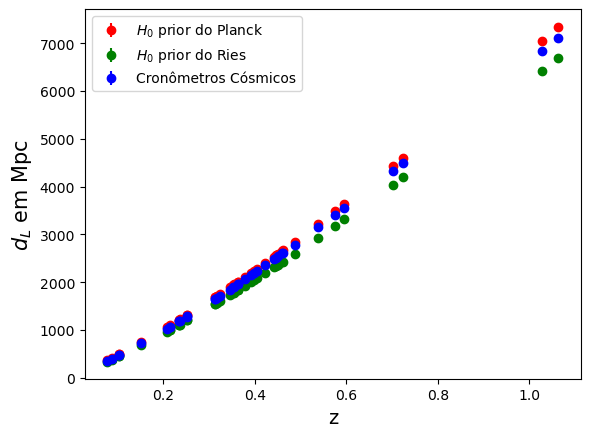

In [11]:
z = dl_planck[:,0]

DL_PLANCK  = dl_planck[:,1]
DL_RIES = dl_ries[:,1]
DL_CC =  dl_cc[:,1]

erro_PLANCK = dl_planck[:,2]
erro_RIES = dl_ries[:,2]
erro_CC = dl_cc[:,2]

plt.errorbar(z, DL_PLANCK, yerr = erro_PLANCK, fmt="o", color="r")
plt.errorbar(z, DL_RIES, yerr = erro_RIES, fmt="o", color="g")
plt.errorbar(z, DL_CC, yerr = erro_CC, fmt="o", color="b")

plt.xlabel('z', size = 14)
plt.ylabel('$d_{L}$ em Mpc', size = 15)
plt.legend(['$H_{0}$ prior do Planck', '$H_{0}$ prior do Ries', 'Cronômetros Cósmicos'], loc='upper left')
plt.show()

# Gas Mass Fraction

Considering the galaxy cluster as a faithful representation of the universe, i.e., a representative sample, the gas mass fraction of the cluster can be modeled as:

$$ f^{\text{obs}}_{\text{gas}} = N\, \left[ \frac{ \Omega_{b}(z) }{ \Omega_{m}(z) } \right] \,\,\, , $$

where $N$ is a factor that depends on the cosmological model and some cluster model characteristics. Additionally, as $\Omega_{b}$ and $\Omega_{m}$ have the same dependence on the scale factor $a$, the ratio $ \frac{ \Omega_{b}(z) }{ \Omega_{m}(z) } $ is independent of the redshift. Using the value of $N$ as given in equation (2) of [Mantz et al](https://arxiv.org/abs/1402.6212) and knowing that $f^{\text{th} }_{\text{gas} } = \eta^{-3} f^{\text{obs} }_{\text{gas} }$, we can write $f^{\text{X-ray} }_{\text{gas}}$ as:

 $$ 
f_{\text{gas}}^{\text{obs}}\left( z\right) = A(z)\, K(z)\, \gamma (z)\, \frac{\Omega _{\text{b}}}{\Omega _{\text{m}}} \, \phi^{3/2}(z)  \left[ \frac{d_{L}^{\text{fid}}\left( z\right) }{d_{L}\left( z\right) }\right] ^{\frac{\,3}{2}} \ , \label{Eq fgas}
$$ 

The function $A(z)$ is given by:

$$
A(z)=\left[\frac{H(z)D_{A}(z)}{H^{\text{fid}}(z)D^{\text{fid}}_{A}(z)} \right]^{\theta} \ \ \text{with} \ \ \theta =0.442 
$$

Definimos as funções A(z) e$ \bar{f}_{gas}$ para nosso uso

In [12]:
def Az(dL_obs, dL_fid, H_obs, H_fid):
    '''
    A_z calcula a função A(z) que depende do parâmetro theta.
    
    '''

    theta = 0.442
    
    return ( (H_obs*dL_obs)/(H_fid*dL_fid) )**theta

In [13]:
def Fgas_th(dL_obs, dL_fid, A, gamma_0, k):
    '''
    Fgas_th é a expressão teórica para a fração de massa do gás
    
    '''
    omega_b = 0.0493
    omega_m = 0.3153
        
    return (           gamma_0*K*A*(omega_b/omega_m)*((dL_fid/dL_obs)**(3.0/2.0))          )

## Dados de fração de massa

In [14]:
f_gas_data = pd.read_csv('GMF.csv')
f_gas_array = np.array(f_gas_data)

In [15]:
z = f_gas_array[0:,0]
fgas = f_gas_array[0:,1]
fgas_erro = f_gas_array[0:,2]

(0.038, 1.113)

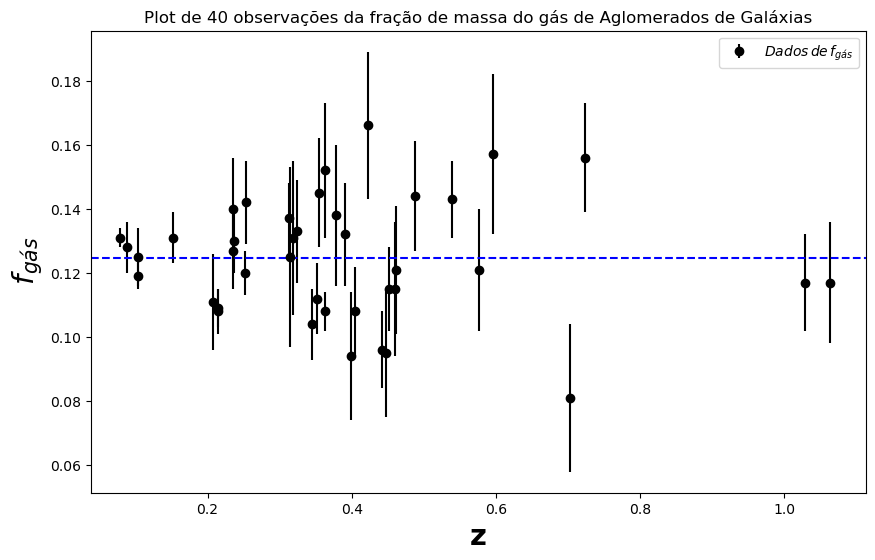

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
plt.errorbar(z, fgas, yerr=fgas_erro, color='black', label = r'$Dados\, de\, f_{gás}$', fmt="o")
ax.set(title="Plot de 40 observações da fração de massa do gás de Aglomerados de Galáxias")
plt.axhline(y = np.mean(fgas), color = 'blue', linestyle = '--') 
plt.xlabel('z', fontsize=21, fontweight='bold')
plt.ylabel(r'$\, f_{gás} \, $', fontsize=21, fontweight='bold')
ax.legend(loc='upper right')
plt.xlim([z.min()-0.04,z.max()+0.05])

Com as definições das funções para a fração de massa e a abertura angular junto aos dados partimos para a criação das listas da distância de luminosidade $d_{L}$ fiducial (usando $\Lambda$-CDM) e os parâmetros de abertura $A(z)$ para cada um dos priors ( Cronômetros Cósmicos, Ries e Planck).

In [17]:
cc = []
planck = []
ries = []
for item in z:
    a = H_z_th(omega_m, 0, h_CC, -1, item)
    b = H_z_th(omega_m, 0, h_PLANCK, -1, item)
    c = H_z_th(omega_m, 0, h_RIES, -1, item)
    cc.append(a)
    planck.append(b)
    ries.append(c)
    
H_CC = np.array(cc)
H_PLANCK = np.array(planck)
H_RIES = np.array(ries)

In [18]:
h_f = []
for item in z:
    h = H_z_th(omega_m, 0, h_fid, -1, item)
    h_f.append(h)

H_fid = np.array(h_f)
H_fid


dl=[]
for item in z:
    dist = DL_fid(item)
    dl.append(dist)

DL_FID= np.array(dl)

In [19]:
A_CC = Az(DL_CC, DL_FID, H_CC, H_fid)
A_PLANCK = Az(DL_PLANCK, DL_FID, H_PLANCK, H_fid)
A_RIES = Az(DL_RIES, DL_FID, H_RIES, H_fid)

In [20]:
FGas_CC = Fgas_th(DL_CC, DL_FID, A_CC, gamma, K)
FGas_PLANCK = Fgas_th(DL_PLANCK, DL_FID, A_PLANCK, gamma, K)
FGas_RIES = Fgas_th(DL_RIES, DL_FID, A_RIES, gamma, K)

# Modelo 1

### Função $\chi^{2}$ e fração de massa do gás para o modelo 1:

Partido do log da likelihood, temos 


$$
    \ln\,\mathcal{P} \left( y^{\text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{ \text{ob} }}\right) \propto -\frac{1}{2}\chi^2 \left( y^{ \text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{\text{ob} }}\right)  =
    -\frac{1}{2} \sum_n \left[
        \frac{(y^{\text{th} }(z_n)-y^{\text{ob} }_{n})^2}{\sigma_{y^{\text{ob} }_n}^2}
    \right] \,\,\, ,
$$

De modo que para o primeiro modelo, teremos:

$$
y^{\text{th} }(z_n) = (1+ c_{1}z)^{3/2}\equiv \zeta(z) \,\,\,\, .
$$


Assim, para esse modelo, o $\chi^{2}$ será:

$$
\chi^{2}=\sum_{i=1}^{40}\frac{ \left[ (1+ c_{1}z)^{3/2}-
\frac{f_{\text{gas},\ i}^{\text{obs} } }{ \bar{f}_{gas} }\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\text{ .}
$$


O erro médio, $\sigma^{2}_{\text{tot}}$ é escrito como:  

$$
\sigma^{2}_{\text{tot}} =  \Sigma_{n} \, \left[ \frac{\partial \, G(X_{n})}{\partial X_{n}}\right]\sigma^{2}_{X_{n}}
$$

considerando que $G(X_{n})= - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f} }$ temos:

$$ 
\sigma^{2}_{\text{tot} } = \left[ \frac{\partial}{\partial f^{ \text{obs}}_{\text{gás}} } \left( - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{f^{\text{obs}}_{\text{gás}}} + \left[ \frac{\partial}{\partial \bar{f} } \left( - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{\bar{f}}
$$

e assim,

$$ 
 \sigma^{2}_{\text{tot} } = \frac{1}{\bar{f}^{2} } \sigma^{2}_{f^{\text{obs}} } + \frac{f^{ \text{obs}^{2} } }{\bar{f}^{4} }\sigma^{2}_{\bar{f}}
$$


$$ 
 \sigma^{2}_{\text{tot} } =  \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left( \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} }  +  \frac{ \sigma^{2}_{\bar{f}}  }{\bar{f}^{2} } \right)
$$

finalmente $ \sigma^{2}_{\bar{f}}$ é dado do mesmo modo:

$$ 
\sigma^{2}_{\bar{f}} =  \Sigma_{m} \, \left[ \frac{\partial \, H(X_{m})}{\partial X_{m}}\right]\sigma^{2}_{X_{n}}
$$

e assim,

$$ 
\sigma^{2}_{\bar{f}} = \left[ \frac{\partial }{\partial K  } \bar{f} \right]^{2} \sigma^{2}_{K} +  \left[ \frac{\partial }{\partial A  } \bar{f} \right]^{2} \sigma^{2}_{A} +  \left[ \frac{\partial }{\partial \Omega_{b}   } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{b}} +  \left[ \frac{\partial }{\partial \Omega_{m}  } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{m}} +  \left[ \frac{\partial }{\partial D^{*}_{A}  } \bar{f} \right]^{2} \sigma^{2}_{d^{*}_{L} } +  \left[ \frac{\partial }{\partial d_{L}   } \bar{f} \right]^{2} \sigma^{2}_{d_{L} } 
$$


Portanto, o erro em relação à $\bar{f}$,


$$
\frac{\sigma^{2}_{ \bar{f} } }{\bar{f}^{2} } = \left[ \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{ \sigma^{2}_{A} }{A^{2}} \, + \,  \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} }  \, \   \right ]
$$

tomando o cuidado de lembrar que:


$$
 \sigma^{2}_{A}  =  \left( \frac{\partial A}{ \partial \theta } \right)^{2} \sigma^{2}_{\theta} 
$$

isto é,

$$
\sigma^{2}_{A} = \left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}
$$

Concluí-se que a expressão final para o erro médio, no primeiro modelo é:

$$
\sigma^{2}_{\text{tot} } = \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left[ \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} } \, + \, \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \, \frac{\left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}}{A^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} } \,    \right ]
$$

### Priors

Os priors em $\zeta(z)$ para o primeiro modelo, serão escolhidos flats (uniformes). Apesar de não informativa a priori tem a vantagem 
de não se fazer suposição qualquer sobre o parâmetro, exceto o range dos valores.


$$
\ln \, \left[\,\mathcal{P}(\zeta)\,\right] = \left \{\begin{array}{ll}
        0 \,, & \mbox{ if }\, -5 < \zeta\,  < 5. \\
        -\infty \,, & \mbox{ outro }
    \end{array}
    \right .
$$

onde, 

$$
-2\ln\mathcal{P} =   \sum_{i=1}^{40}\frac{ \left[ \zeta(z)-
\frac{f_{\text{gas},\ i}^{\text{X-ray} } }{ \bar{f}_{gas} }\,\,\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\,\, +\,\, \sum_{i=1}^{40}\ln 2\pi{\sigma_{\text{tot}, i}^2} 
$$

In [21]:
def log_prior1(c1):
    '''
    log likelihood para uma prior não informativa, flat nos parâmetros.
    '''
    
    if -5 < c1 < 5:
        return 0.0

    return -np.inf

In [22]:
def chi2_mod1(c1, FGas_th, A, DL_obs, DL_erro):
    '''
    A função que calcula o $\chi^{2}$ para o modelo 1 usando a fração de massa do gás observada, a fração de massa do
    gás calculada em função do parâmetro livre c1.
    
    '''
    
    sigma_K = 0.12
    sigma_gamma = 0.08
    sigma_omega_b = 0.0039
    sigma_omega_m= 0.0073
    sigma_theta = 0.035
    
    
    frac_f_gas = fgas/FGas_th
    
    sigma_tot =(frac_f_gas**2)*(  (fgas_erro/fgas)**2.0 +  (sigma_K/K)**2.0   + (sigma_gamma/gamma)**2.0
                                                                +(sigma_omega_b/omega_b)**2.0 +   (sigma_omega_m*omega_m)**2.0
                                                                + (sigma_theta*np.log(A)/A)**2.0 + ( (2/3)*(DL_erro/DL_obs) )**2    )
    
    
    return (   ( (1+c1*z)**(3/2) - frac_f_gas)**(2) )/ sigma_tot + np.log(2*np.pi*sigma_tot) 
    

### Log da Likelihood para cada caso:

In [23]:
def log_likelihood_CC(c1, FGas_CC, A_CC, DL_CC, erro_CC):
    
    soma = sum(chi2_mod1(c1, FGas_CC, A_CC, DL_CC, erro_CC) ) 
    
    return -0.5*soma

In [24]:
def log_likelihood_PLANCK(c1, FGas_PLANCK, A_PLANCK, DL_PLANCK, erro_PLANCK):
    
    soma = sum(chi2_mod1(c1, FGas_PLANCK, A_PLANCK, DL_PLANCK, erro_PLANCK) ) 
    
    return -0.5*soma

In [25]:
def log_likelihood_RIES(c1, FGas_RIES, A_RIES, DL_RIES, erro_RIES):
    
    soma = sum(chi2_mod1(c1, FGas_RIES, A_RIES, DL_RIES, erro_RIES) ) 
    
    return -0.5*soma

In [26]:
def log_probability_CC(param):
    
    c1 = param
    
    # Flat priors
    lp = log_prior1(c1)
    if not np.isfinite(lp):
        return -np.inf
    
    log_probability_tot = lp + log_likelihood_CC(c1, FGas_CC, A_CC, DL_CC, erro_CC)
    
    return log_probability_tot

In [27]:
def log_probability_PLANCK(param):
    
    c1 = param
    
    # Flat priors
    lp = log_prior1(c1)
    if not np.isfinite(lp):
        return -np.inf
    
    log_probability_tot = lp + log_likelihood_PLANCK(c1, FGas_PLANCK, A_PLANCK, DL_PLANCK, erro_PLANCK)
    
    return log_probability_tot

In [28]:
def log_probability_RIES(param):
    
    c1 = param
    
    # Flat priors
    lp = log_prior1(c1)
    if not np.isfinite(lp):
        return -np.inf
    
    log_probability_tot = lp + log_likelihood_RIES(c1, FGas_RIES, A_RIES, DL_RIES, erro_RIES)
    
    return log_probability_tot

# MCMC

### Para o caso de CC

In [29]:
c1_ini = 0.03

totalsteps = 3200

param_ini = [c1_ini]
dim = len(param_ini)

pos = param_ini + 1e-4 * np.random.randn(32,dim)
nwalkers, ndim = pos.shape

sampler_CC = emcee.EnsembleSampler(nwalkers, ndim, log_probability_CC)

sampler_CC.run_mcmc(pos, totalsteps, progress=True);

100%|█████████████████████████████████| 3200/3200 [00:04<00:00, 770.22it/s]


In [30]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler_CC.acceptance_fraction)))

Mean acceptance fraction: 0.806


### For Planck

In [31]:
c1_ini = 0.03

totalsteps = 3200

param_ini = [c1_ini]
dim = len(param_ini)

pos = param_ini + 1e-4 * np.random.randn(32,dim)
nwalkers, ndim = pos.shape

sampler_PLANCK = emcee.EnsembleSampler(nwalkers, ndim, log_probability_PLANCK)

sampler_PLANCK.run_mcmc(pos, totalsteps, progress=True);

100%|█████████████████████████████████| 3200/3200 [00:03<00:00, 871.23it/s]


In [32]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler_PLANCK.acceptance_fraction)))

Mean acceptance fraction: 0.806


### For Ries

In [33]:
c1_ini = 0.03

totalsteps = 3200

param_ini = [c1_ini]
dim = len(param_ini)

pos = param_ini + 1e-4 * np.random.randn(32,dim)
nwalkers, ndim = pos.shape

sampler_RIES = emcee.EnsembleSampler(nwalkers, ndim, log_probability_RIES)

sampler_RIES.run_mcmc(pos, totalsteps, progress=True);

100%|█████████████████████████████████| 3200/3200 [00:03<00:00, 863.66it/s]


In [34]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler_RIES.acceptance_fraction)))

Mean acceptance fraction: 0.804


## Série temporal do caminhante

Text(0.5, 0, 'Número de Passos')

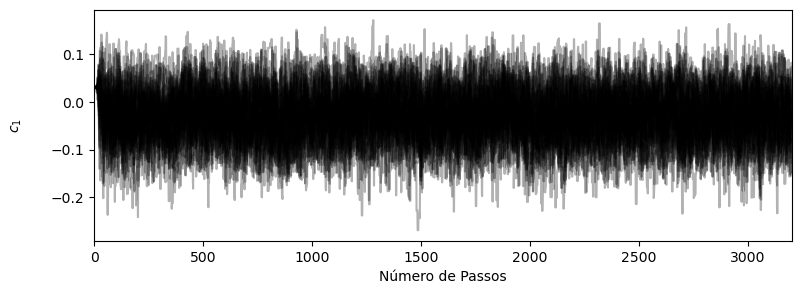

In [35]:
fig, axes = plt.subplots(ndim, figsize=(9,3), sharex=True)
samples = sampler_CC.get_chain()
labels = ["$c_{1}$"]
for i in range(ndim):
    ax = axes
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("Número de Passos")

Text(0.5, 0, 'Número de Passos')

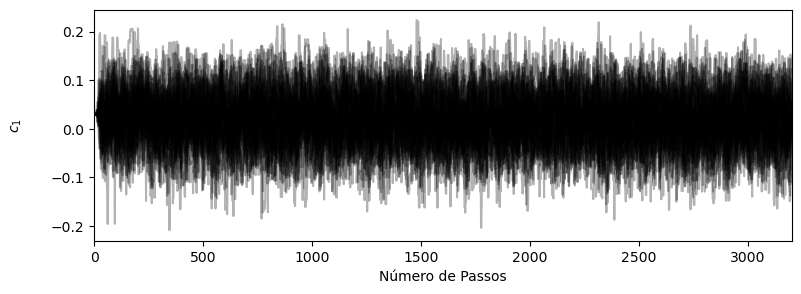

In [36]:
fig, axes = plt.subplots(ndim, figsize=(9,3), sharex=True)
samples = sampler_PLANCK.get_chain()
labels = ["$c_{1}$"]
for i in range(ndim):
    ax = axes
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("Número de Passos")

Text(0.5, 0, 'Número de Passos')

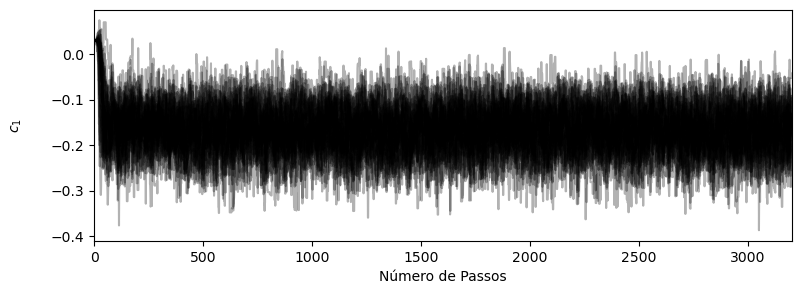

In [37]:
fig, axes = plt.subplots(ndim, figsize=(9,3), sharex=True)
samples = sampler_RIES.get_chain()
labels = ["$c_{1}$"]
for i in range(ndim):
    ax = axes
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("Número de Passos")

## Burn-In

In [38]:
# tempo de auto-correlação
tau_CC = sampler_CC.get_autocorr_time()
print(tau_CC)

[24.24921639]


In [39]:
flat_samples_CC = sampler_CC.get_chain(discard=250, thin=15, flat=True)
print("lista Anterior:",sampler_CC.get_chain().shape)
print("Nova lista:",flat_samples_CC.shape)

lista Anterior: (3200, 32, 1)
Nova lista: (6272, 1)


In [40]:
tau_PLANCK = sampler_PLANCK.get_autocorr_time()
print(tau_PLANCK)

[25.77454934]


In [41]:
flat_samples_PLANCK = sampler_PLANCK.get_chain(discard=250, thin=15, flat=True)
print("lista Anterior:",sampler_PLANCK.get_chain().shape)
print("Nova lista:",flat_samples_PLANCK.shape)

lista Anterior: (3200, 32, 1)
Nova lista: (6272, 1)


In [42]:
tau_RIES = sampler_RIES.get_autocorr_time()
print(tau_PLANCK)

[25.77454934]


In [43]:
flat_samples_RIES = sampler_RIES.get_chain(discard=250, thin=15, flat=True)
print("lista Anterior:",sampler_RIES.get_chain().shape)
print("Nova lista:",flat_samples_RIES.shape)

lista Anterior: (3200, 32, 1)
Nova lista: (6272, 1)


## Saving the data

In [44]:
np.savetxt("Saved Data/MCMC_Param_modelo_c1_CC.csv", flat_samples_CC, delimiter=",")
np.savetxt("Saved Data/MCMC_Param_modelo_c1_PLANCK.csv", flat_samples_PLANCK, delimiter=",")
np.savetxt("Saved Data/MCMC_Param_modelo_c1_RIES.csv", flat_samples_RIES, delimiter=",")

# Resultados do Modelo 1

Neste modelo, $c(z) = (1+c_{1}z)$

### Using CC

In [45]:
from IPython.display import display, Math, Latex

best_value_CC = []

for i in range(ndim):
    mcmc_CC = np.percentile(flat_samples_CC[:, i], [22, 24.1, 65])
    best_value_CC.append(mcmc_CC[1])
    q = np.diff(mcmc_CC)
    txt = "{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{+{2:.5f}}}"
    txt = txt.format(mcmc_CC[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

In [46]:
best_c1 = best_value_CC[0]
best_c1

-0.06652359645312725

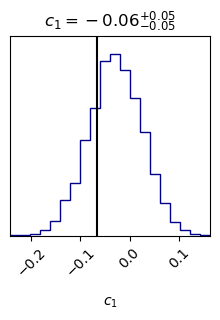

In [47]:
MCMC_flatsamples_CC = np.vstack(flat_samples_CC)

best_c1 = best_value_CC[0]

figure = corner.corner(MCMC_flatsamples_CC, labels=[r"$c_{1}$"], #quantiles=[0.22, .28, 0.65], 
    titles=[r"$c_{1}=-0.06^{+ 0.05}_{-0.05}$"],
    show_titles=False,
    title_kwargs={"fontsize": 12}, color="darkblue")
axes = np.array(figure.axes).reshape((ndim, ndim))
ax = axes[0,0]
ax.set_title(r'$c_{1}= -0.06^{+0.05}_{-0.05}$')
ax.axvline(best_c1, color="black")

### Using Planck

In [48]:
from IPython.display import display, Math, Latex

best_value_PLANCK = []

for i in range(ndim):
    mcmc_PLANCK = np.percentile(flat_samples_PLANCK[:, i], [22, 25, 65])
    best_value_PLANCK.append(mcmc_PLANCK[1])
    q = np.diff(mcmc_PLANCK)
    txt = "{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{+{2:.5f}}}"
    txt = txt.format(mcmc_PLANCK[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

In [49]:
best_c1_P = best_value_PLANCK[0]
best_c1_P

-0.018847629826651596

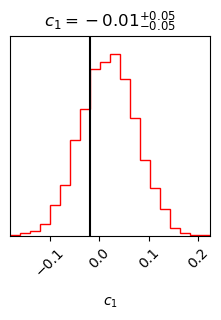

In [50]:
MCMC_flatsamples_PLANCK= np.vstack(flat_samples_PLANCK)

best_c1_P = best_value_PLANCK[0]

figure = corner.corner(MCMC_flatsamples_PLANCK, labels=[r"$c_{1}$"], #quantiles=[0.22, .28, 0.65],
    show_titles=False,
    title_kwargs={"fontsize": 12}, color="red")
axes = np.array(figure.axes).reshape((ndim, ndim))
ax = axes[0,0]
ax.set_title(r'$c_{1}= -0.01^{+0.05}_{-0.05}$')
ax.axvline(best_c1_P, color="black")

### Using Ries

In [51]:
from IPython.display import display, Math, Latex

best_value_RIES = []

for i in range(ndim):
    mcmc_RIES = np.percentile(flat_samples_RIES[:, i], [22, 25, 65])
    best_value_RIES.append(mcmc_RIES[1])
    q = np.diff(mcmc_RIES)
    txt = "{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{+{2:.5f}}}"
    txt = txt.format(mcmc_RIES[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

In [52]:
best_c1_R = best_value_RIES[0]
best_c1_R

-0.20232839004843364

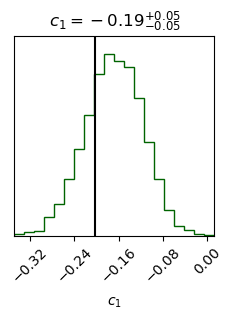

In [53]:
MCMC_flatsamples_RIES= np.vstack(flat_samples_RIES)

best_c1_R = best_value_RIES[0]

figure = corner.corner(MCMC_flatsamples_RIES, labels=[r"$c_{1}$"], #quantiles=[0.22, .28, 0.65],
    show_titles=False,
    title_kwargs={"fontsize": 12}, color="darkgreen")
axes = np.array(figure.axes).reshape((ndim, ndim))
ax = axes[0,0]
ax.set_title(r'$c_{1}= -0.19^{+0.05}_{-0.05}$')
ax.axvline(best_c1_R, color="black")

# Modelo 2

### Função $\chi^{2}$ e fração de massa do gás para o modelo 1:

Partido do log da likelihood, temos 


$$
    \ln\,\mathcal{P} \left( y^{\text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{ \text{ob} }}\right) \propto -\frac{1}{2}\chi^2 \left( y^{ \text{th} }\,|\,y^{ \text{ob} },\sigma_{y^{\text{ob} }}\right)  =
    -\frac{1}{2} \sum_n \left[
        \frac{(y^{\text{th} }(z_n)-y^{\text{ob} }_{n})^2}{\sigma_{y^{\text{ob} }_n}^2}
    \right] \,\,\, ,
$$

De modo que para o primeiro modelo, teremos:

$$
y^{\text{th} }(z_n) = \left(1+\gamma_{1}z \right)(1+ c_{1}z)^{3/2} \,\,\,\, .
$$


Assim, para esse modelo, o $\chi^{2}$ será:

$$
\chi^{2}=\sum_{i=1}^{40}\frac{ \left[  \left(1+\gamma_{1}z \right)(1+ c_{1}z)^{3/2}-
\frac{f_{\text{gas},\ i}^{\text{obs} } }{ \bar{f}_{gas} }\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\text{ .}
$$


O erro médio, $\sigma^{2}_{\text{tot}}$ é escrito como:  

$$
\sigma^{2}_{\text{tot}} =  \Sigma_{n} \, \left[ \frac{\partial \, G(X_{n})}{\partial X_{n}}\right]\sigma^{2}_{X_{n}}
$$

considerando que $G(X_{n})= - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f} }$ temos:

$$ 
\sigma^{2}_{\text{tot} } = \left[ \frac{\partial}{\partial f^{ \text{obs}}_{\text{gás}} } \left( - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{f^{\text{obs}}_{\text{gás}}} + \left[ \frac{\partial}{\partial \bar{f} } \left( - \frac{ f^{\text{obs}}_{\text{gás}} }{ \bar{f}}\right) \right]^{2} \sigma^{2}_{\bar{f}}
$$

e assim,

$$ 
 \sigma^{2}_{\text{tot} } = \frac{1}{\bar{f}^{2} } \sigma^{2}_{f^{\text{obs}} } + \frac{f^{ \text{obs}^{2} } }{\bar{f}^{4} }\sigma^{2}_{\bar{f}}
$$


$$ 
 \sigma^{2}_{\text{tot} } =  \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left( \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} }  +  \frac{ \sigma^{2}_{\bar{f}}  }{\bar{f}^{2} } \right)
$$

finalmente $ \sigma^{2}_{\bar{f}}$ é dado do mesmo modo:

$$ 
\sigma^{2}_{\bar{f}} =  \Sigma_{m} \, \left[ \frac{\partial \, H(X_{m})}{\partial X_{m}}\right]\sigma^{2}_{X_{n}}
$$

e assim,

$$ 
\sigma^{2}_{\bar{f}} = \left[ \frac{\partial }{\partial K  } \bar{f} \right]^{2} \sigma^{2}_{K} +  \left[ \frac{\partial }{\partial A  } \bar{f} \right]^{2} \sigma^{2}_{A} +  \left[ \frac{\partial }{\partial \Omega_{b}   } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{b}} +  \left[ \frac{\partial }{\partial \Omega_{m}  } \bar{f} \right]^{2} \sigma^{2}_{\Omega_{m}} +  \left[ \frac{\partial }{\partial D^{*}_{A}  } \bar{f} \right]^{2} \sigma^{2}_{d^{*}_{L} } +  \left[ \frac{\partial }{\partial d_{L}   } \bar{f} \right]^{2} \sigma^{2}_{d_{L} } 
$$


Portanto, o erro em relação à $\bar{f}$,


$$
\frac{\sigma^{2}_{ \bar{f} } }{\bar{f}^{2} } = \left[ \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{ \sigma^{2}_{A} }{A^{2}} \, + \,  \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} }  \, \   \right ]
$$

tomando o cuidado de lembrar que:


$$
 \sigma^{2}_{A}  =  \left( \frac{\partial A}{ \partial \theta } \right)^{2} \sigma^{2}_{\theta} 
$$

isto é,

$$
\sigma^{2}_{A} = \left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}
$$

Concluí-se que a expressão final para o erro médio, no primeiro modelo é:

$$
\sigma^{2}_{\text{tot} } = \frac{f^{ \text{obs}^{2} } }{\bar{f}^{2} } \left[ \frac{ \sigma^{2}_{f^{\text{obs}} }  }{{f}^{\text{obs}^{2}} } \, + \, \frac{ \sigma^{2}_{ K } }{ K^{2} } \, + \, \frac{\sigma_{\gamma}^{2}}{\gamma^{2} }\, + \, \frac{\left( \mbox{log}\, A\right)^{2} \sigma^{2}_{\theta}}{A^{2}} \, + \,  \frac{ \sigma^{2}_{ \Omega_{b} } }{\Omega_{b}^{2}} \, + \, \sigma^{2}_{\Omega_{m}}\cdot \Omega_{m}^{2} \, + \, \left(\frac{2}{3}\right)^{2} \frac{\sigma^{2}_{d_{L} } }{d_{L}^{2} } \,    \right ]
$$

### Priors

Os priors em $\zeta(z)$ para o primeiro modelo, serão escolhidos flats (uniformes). Apesar de não informativa a priori tem a vantagem 
de não se fazer suposição qualquer sobre o parâmetro, exceto o range dos valores.


$$
\ln \, \left[\,\mathcal{P}(\gamma_{1}, c_{1})\,\right] = \left \{\begin{array}{ll}
        0 \,, & \mbox{ if }\, -5 < \gamma_{1}\, , c_{1}  < 5. \\
        -\infty \,, & \mbox{ outro }
    \end{array}
    \right .
$$

onde, 

$$
-2\ln\mathcal{P} =   \sum_{i=1}^{40}\frac{ \left[\left(1+\gamma_{1}z \right)(1+ c_{1}z)^{3/2} -
\frac{f_{\text{gas},\ i}^{\text{X-ray} } }{ \bar{f}_{gas} }\,\,\,\,\, \right] ^{2}}{\sigma _{\text{
tot},\ i}^{2}}\,\, +\,\, \sum_{i=1}^{40}\ln 2\pi{\sigma_{\text{tot}, i}^2} 
$$

In [54]:
def log_prior2(gama1, c1):
    '''
    log likelihood para uma prior não informativa, flat nos parâmetros.
    '''
    
    if -5 < gama1 < 5 and -0.8 < c1 <0.8:
        return 0.0

    return -np.inf

In [63]:
def chi2_mod2(gama1, c1, FGas_th, A, DL_obs, DL_erro):
    '''
    A função que calcula o $\chi^{2}$ para o modelo 1 usando a fração de massa do gás observada, a fração de massa do
    gás calculada em função do parâmetro livre c1.
    
    '''
    
    sigma_K = 0.12
    sigma_gamma = 0.08
    sigma_omega_b = 0.0039
    sigma_omega_m= 0.0073
    sigma_theta = 0.035
    
    
    frac_f_gas = fgas/FGas_th
    
    sigma_tot =(frac_f_gas**2)*(  (fgas_erro/fgas)**2.0 +  (sigma_K/K)**2.0   + (sigma_gamma/gamma)**2.0
                                                                +(sigma_omega_b/omega_b)**2.0 +   (sigma_omega_m*omega_m)**2.0
                                                                + (sigma_theta*np.log(A)/A)**2.0 + ( (2/3)*(DL_erro/DL_obs) )**2    )
    
    
    return (   (  (1+gama1*z)*((1+c1*z)**(3/2)) - frac_f_gas)**(2) )/ sigma_tot + np.log(2*np.pi*sigma_tot) 
    

### Log da Likelihood para cada caso

In [64]:
def log_likelihood_CC2(gama1, c1, FGas_CC, A_CC, DL_CC, erro_CC):
    
    soma = sum(chi2_mod2(gama1, c1, FGas_CC, A_CC, DL_CC, erro_CC) ) 
    
    return -0.5*soma

In [65]:
def log_likelihood_PLANCK2(gama1, c1, FGas_PLANCK, A_PLANCK, DL_PLANCK, erro_PLANCK):
    
    soma = sum(chi2_mod2(gama1, c1, FGas_PLANCK, A_PLANCK, DL_PLANCK, erro_PLANCK) ) 
    
    return -0.5*soma

In [66]:
def log_likelihood_RIES2(gama1, c1, FGas_RIES, A_RIES, DL_RIES, erro_RIES):
    
    soma = sum(chi2_mod2(gama1, c1, FGas_RIES, A_RIES, DL_RIES, erro_RIES) ) 
    
    return -0.5*soma

In [67]:
def log_probability_CC2(param):
    
    gama1, c1 = param
    
    # Flat priors
    lp = log_prior2(gama1, c1)
    if not np.isfinite(lp) or np.isnan(lp):
        return -np.inf
    
    log_probability_tot = lp + log_likelihood_CC2(gama1, c1, FGas_CC, A_CC, DL_CC, erro_CC)
    
    return log_probability_tot

In [68]:
def log_probability_PLANCK2(param):
    
    gama1, c1 = param
    
    # Flat priors
    lp = log_prior2(gama1, c1)
    if not np.isfinite(lp)or np.isnan(lp):
        return -np.inf
    
    log_probability_tot = lp + log_likelihood_PLANCK2(gama1, c1, FGas_PLANCK, A_PLANCK, DL_PLANCK, erro_PLANCK)
    
    return log_probability_tot

In [69]:
def log_probability_RIES2(param):
    
    gama1, c1 = param
    
    # Flat priors
    lp = log_prior2(gama1, c1)
    if not np.isfinite(lp) or np.isnan(lp):
        return -np.inf
    
    log_probability_tot = lp + log_likelihood_RIES2(gama1, c1, FGas_RIES, A_RIES, DL_RIES, erro_RIES)
    
    return log_probability_tot

# MCMC

### Using CC

In [70]:
gama_1_ini = 0.001
c1_ini = 0.1

totalsteps =198500

param_ini = [gama_1_ini, c1_ini]
dim = len(param_ini)

pos = param_ini + 1e-4*np.random.randn(16,dim)
nwalkers, ndim = pos.shape

sampler_CC2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_CC2)

sampler_CC2.run_mcmc(pos, totalsteps, progress=True);

100%|████████████████████████████| 198500/198500 [02:53<00:00, 1142.20it/s]


### Using Planck

In [71]:
gama_1_ini = 0.001
c1_ini = 0.1

totalsteps =195600

param_ini = [gama_1_ini, c1_ini]
dim = len(param_ini)

pos = param_ini + 1e-4 * np.random.randn(18,dim)
nwalkers, ndim = pos.shape

sampler_PLANCK2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_PLANCK2)

sampler_PLANCK2.run_mcmc(pos, totalsteps, progress=True);

100%|████████████████████████████| 195600/195600 [03:00<00:00, 1082.41it/s]


### Using RIes

In [72]:
gama_1_ini = 0.001
c1_ini = 0.1

totalsteps =195500

param_ini = [gama_1_ini, c1_ini]
dim = len(param_ini)

pos = param_ini + 1e-4 * np.random.randn(16,dim)
nwalkers, ndim = pos.shape

sampler_RIES2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_RIES2)

sampler_RIES2.run_mcmc(pos, totalsteps, progress=True);

100%|████████████████████████████| 195500/195500 [02:58<00:00, 1094.33it/s]


## Serie temporal dos caminhantes aleatórios

Text(0.5, 0, 'Número de Passos')

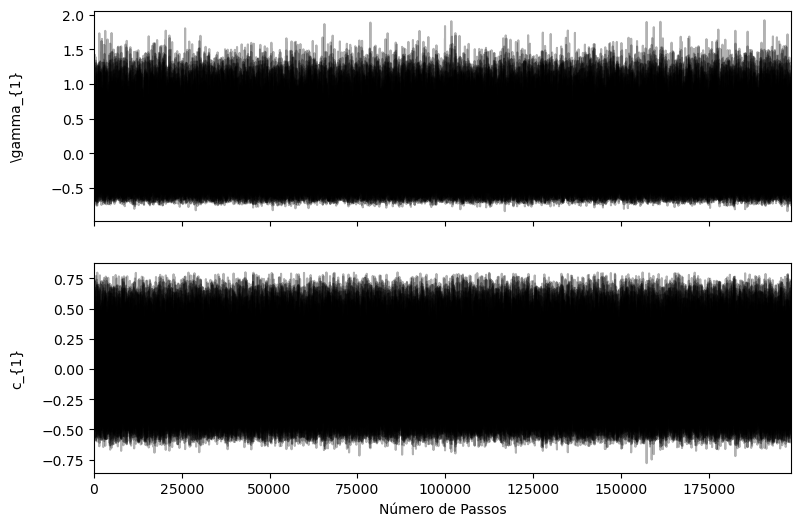

In [76]:
fig, axes = plt.subplots(ndim, figsize=(9, 6), sharex=True)
samples_CC2 = sampler_CC2.get_chain()
labels = [r"\gamma_{1}",r"c_{1}"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_CC2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_CC2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Número de Passos")

Text(0.5, 0, 'Número de Passos')

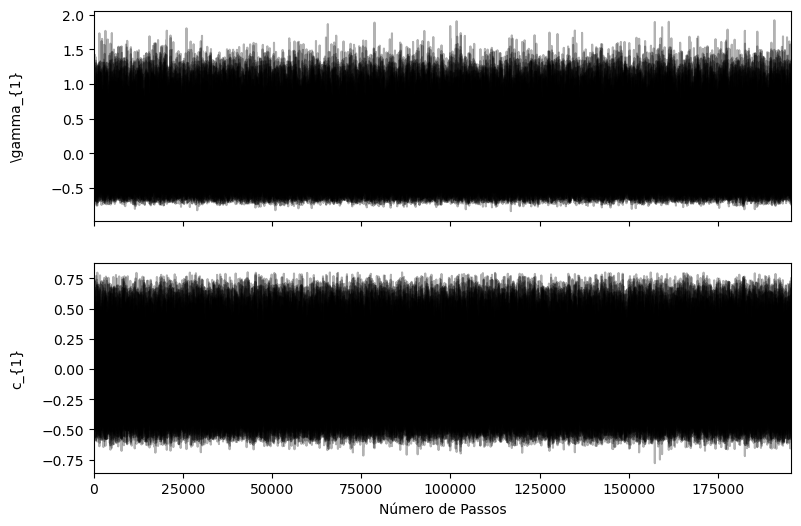

In [77]:
fig, axes = plt.subplots(ndim, figsize=(9, 6), sharex=True)
samples_PLANCK2 = sampler_PLANCK2.get_chain()
labels = [r"\gamma_{1}",r"c_{1}"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_CC2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_PLANCK2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Número de Passos")

Text(0.5, 0, 'Número de Passos')

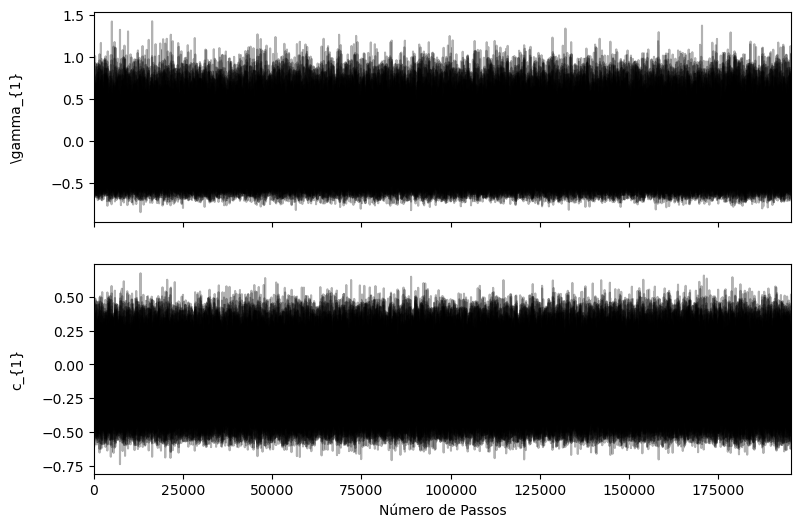

In [78]:
fig, axes = plt.subplots(ndim, figsize=(9, 6), sharex=True)
samples_RIES2 = sampler_RIES2.get_chain()
labels = [r"\gamma_{1}",r"c_{1}"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_RIES2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_RIES2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Número de Passos")

## Burn-In

In [79]:
# tempo de auto-correlação
tau_CC2 = sampler_CC2.get_autocorr_time()
print(tau_CC2)

[60.72512417 61.48962798]


In [80]:
flat_samples_CC2 = sampler_CC2.get_chain(discard=1550, thin=15, flat=True)
print("lista Anterior:",sampler_CC2.get_chain().shape)
print("Nova lista:",flat_samples_CC2.shape)

lista Anterior: (198500, 16, 2)
Nova lista: (210080, 2)


In [81]:
# tempo de auto-correlação
tau_PLANCK2 = sampler_PLANCK2.get_autocorr_time()
print(tau_PLANCK2)

[77.0506113  78.01532568]


In [82]:
flat_samples_PLANCK2 = sampler_PLANCK2.get_chain(discard=1250, thin=15, flat=True)
print("lista Anterior:",sampler_PLANCK2.get_chain().shape)
print("Nova lista:",flat_samples_PLANCK2.shape)

lista Anterior: (195600, 18, 2)
Nova lista: (233208, 2)


In [83]:
# tempo de auto-correlação
tau_RIES2 = sampler_RIES2.get_autocorr_time()
print(tau_RIES2)

[40.02831833 39.97374021]


In [84]:
flat_samples_RIES2 = sampler_RIES2.get_chain(discard=1250, thin=15, flat=True)
print("lista Anterior:",sampler_RIES2.get_chain().shape)
print("Nova lista:",flat_samples_RIES2.shape)

lista Anterior: (195500, 16, 2)
Nova lista: (207200, 2)


# Saving Data

In [85]:
np.savetxt("Saved Data/MCMC_Param_modelo_c1_gama1_CC.csv", flat_samples_CC2, delimiter=",")
np.savetxt("Saved Data/MCMC_Param_modelo_c1_gama1_PLANCK.csv", flat_samples_PLANCK2, delimiter=",")
np.savetxt("Saved Data/MCMC_Param_modelo_c1_gama1_RIES.csv", flat_samples_RIES2, delimiter=",")

# Resultados do Modelo 2

Neste modelo, $c(z) = (1+c_{1}z)$ e $\gamma(z) = (1 + \gamma_{1}z)$

### Using CC

In [86]:
from IPython.display import display, Math, Latex

best_value_CC2 = []

for i in range(ndim):
    mcmc_CC2 = np.percentile(flat_samples_CC2[:, i], [25, 51.3, 90])
    best_value_CC2.append(mcmc_CC2[1])
    q = np.diff(mcmc_CC2)
    txt = "{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{+{2:.5f}}}"
    txt = txt.format(mcmc_CC2[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

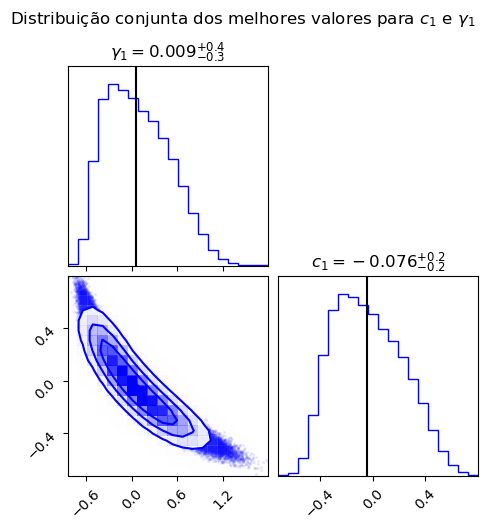

In [87]:
MCMC_flatsamples_CC2 = np.vstack(flat_samples_CC2)

best_c1_CC2 = best_value_CC2[1]
best_gama1_CC2 = best_value_CC2[0]

figure = corner.corner(MCMC_flatsamples_CC2, color='blue', smooth=1.05, 
                       title_kwargs={"fontsize": 12}, 
                       plot_contours =True)
figure.suptitle("\n".join([r'Distribuição conjunta dos melhores valores para $c_{1}$ e $\gamma_{1}$']), y=1.03)
axes = np.array(figure.axes).reshape((ndim, ndim))
axes[0, 0].set_title(r'$\gamma_{1}=0.009^{+0.4}_{-0.3}$')
axes[0, 0].axvline(x=best_gama1_CC2, color='black')
axes[1, 1].set_title(r'$c_{1}= - 0.076^{+0.2}_{-0.2}$')
axes[1, 1].axvline(x = best_c1_CC2, color = 'black', label = 'axvline - full height')


### Using Planck

In [88]:
from IPython.display import display, Math, Latex

best_value_PLANCK2 = []

for i in range(ndim):
    mcmc_PLANCK2 = np.percentile(flat_samples_PLANCK2[:, i], [25, 75, 90])
    best_value_PLANCK2.append(mcmc_PLANCK2[1])
    q = np.diff(mcmc_PLANCK2)
    txt = "{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{+{2:.5f}}}"
    txt = txt.format(mcmc_PLANCK2[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

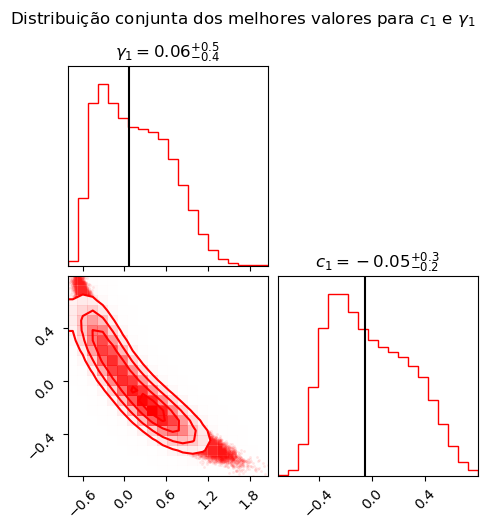

In [89]:
MCMC_flatsamples_PLANCK2 = np.vstack(flat_samples_PLANCK2)

best_c1_PLANCK2 = best_value_PLANCK2[1]
best_gama1_PLANCK2 = best_value_PLANCK2[0]

figure = corner.corner(MCMC_flatsamples_PLANCK2, color='red', smooth=1.25, plot_contours =True)
figure.suptitle("\n".join([r'Distribuição conjunta dos melhores valores para $c_{1}$ e $\gamma_{1}$']), y=1.03)
axes = np.array(figure.axes).reshape((ndim, ndim))
axes[0, 0].set_title(r'$\gamma_{1}=0.06^{+0.5}_{-0.4}$')
axes[0, 0].axvline(x=0.06, color='black')
axes[1, 1].set_title(r'$c_{1}= -0.05^{+0.3}_{-0.2}$')
axes[1, 1].axvline(x = -0.05, color = 'black', label = 'axvline - full height')


### Using Ries

In [90]:
from IPython.display import display, Math, Latex

best_value_RIES2 = []

for i in range(ndim):
    mcmc_RIES2 = np.percentile(flat_samples_RIES2[:, i], [25, 61, 90])
    best_value_RIES2.append(mcmc_RIES2[1])
    q = np.diff(mcmc_RIES2)
    txt = "{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{+{2:.5f}}}"
    txt = txt.format(mcmc_RIES2[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>